<a href="https://colab.research.google.com/github/Aparna-Ranjith/Projects/blob/master/Caltech101_sota_resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretrainedmodels

In [ ]:
!curl -O http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  8356k      0  0:00:15  0:00:15 --:--:-- 10.0M


In [ ]:
import tarfile

In [ ]:
with tarfile.open('/content/101_ObjectCategories.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [ ]:
!pip install imutils

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import pretrainedmodels
import torchvision

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

'''
SEED Everything
'''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # torch.backends.cudnn.deterministic = True
    # os.environ['PYTHONHASHSEED']=str(SEED)
    # torch.backends.cudnn.benchmark = False # as all the inputs are not of same size
SEED=42
seed_everything(SEED=SEED)
'''
SEED Everything
'''

'\nSEED Everything\n'

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

epochs = 5

In [ ]:
image_paths = list(paths.list_images('/content/101_ObjectCategories'))

In [ ]:
# new_path = list(os.path.realpath('/content/101_ObjectCategories'))
# for i in range(5):
#     print(new_path[i])

In [ ]:
data = []
labels = []
label_names = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    label_names.append(label)
    labels.append(label)

In [ ]:
print((labels[0]))

chair


In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(len(lb.classes_))
print(labels)

101
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [ ]:
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    # print(lb.classes_[i])
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

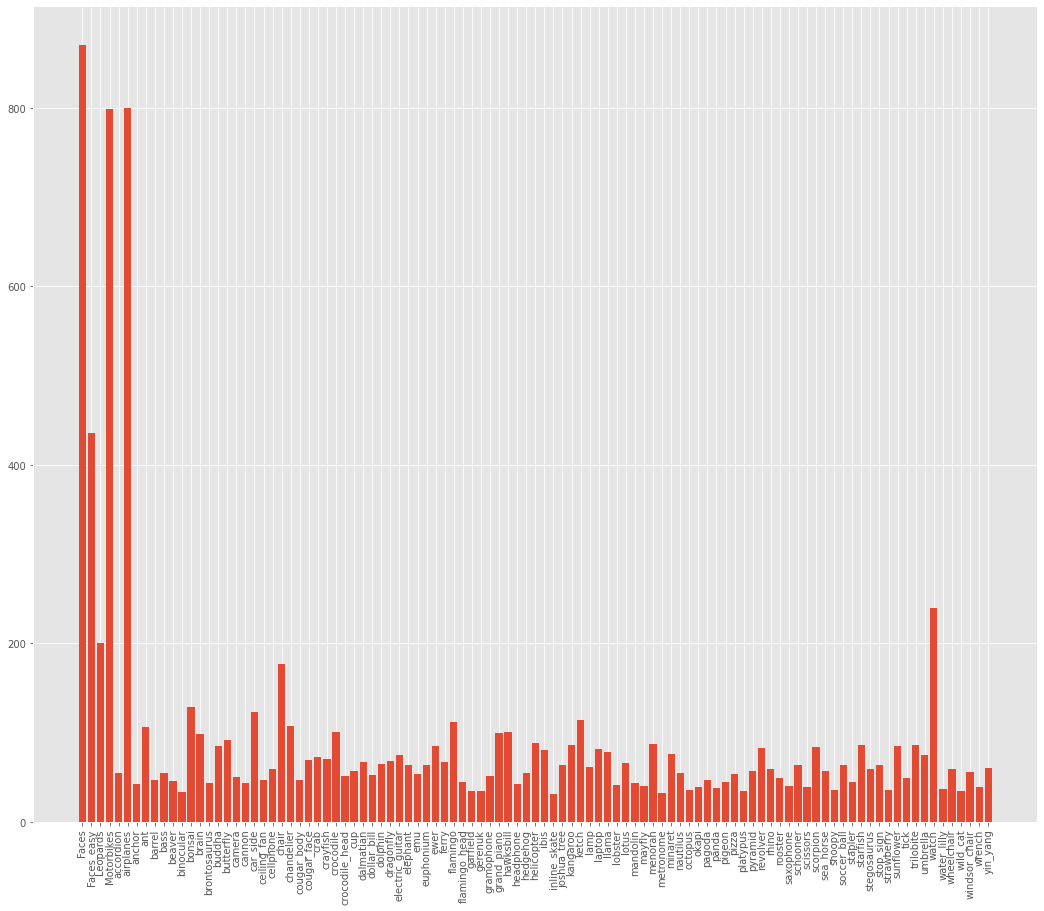

In [ ]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


In [ ]:
# define transforms
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
    #  transforms.RandomRotation((-30, 30)),
    #  transforms.RandomHorizontalFlip(p=0.5),
    #  transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [ ]:
# custom dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
 
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


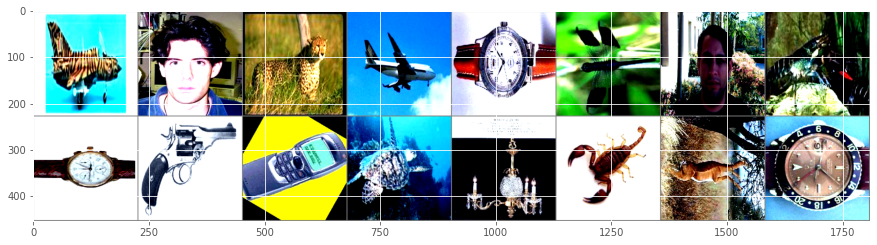

In [ ]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        self.l0 = nn.Linear(512, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = ResNet34(pretrained=True).to(device)
print(model)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# loss function
criterion = nn.CrossEntropyLoss()

ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples")

#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

# training function
def fit(model, dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # print(outputs)
        # print(torch.max(target, 1)[1])
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

print((end-start)/60, 'minutes')

  0%|          | 0/325 [00:00<?, ?it/s]

Training on 5205 examples, validating on 1736 examples
Epoch 1 of 5
Training


326it [01:10,  4.62it/s]
  1%|          | 1/108 [00:00<00:15,  6.83it/s]

Train Loss: 0.1036, Train Acc: 67.13
Validating


109it [00:11,  9.11it/s]                         
  0%|          | 0/325 [00:00<?, ?it/s]

Val Loss: 0.0247, Val Acc: 91.36
Epoch 2 of 5
Training


326it [01:11,  4.58it/s]
  1%|          | 1/108 [00:00<00:15,  6.77it/s]

Train Loss: 0.0198, Train Acc: 94.79
Validating


109it [00:11,  9.31it/s]                         
  0%|          | 0/325 [00:00<?, ?it/s]

Val Loss: 0.0156, Val Acc: 94.07
Epoch 3 of 5
Training


326it [01:11,  4.59it/s]
  1%|          | 1/108 [00:00<00:11,  9.55it/s]

Train Loss: 0.0075, Train Acc: 98.27
Validating


109it [00:11,  9.24it/s]                         
  0%|          | 0/325 [00:00<?, ?it/s]

Val Loss: 0.0125, Val Acc: 94.99
Epoch 4 of 5
Training


326it [01:10,  4.59it/s]
  1%|          | 1/108 [00:00<00:11,  9.47it/s]

Train Loss: 0.0034, Train Acc: 99.46
Validating


109it [00:11,  9.27it/s]                         
  0%|          | 0/325 [00:00<?, ?it/s]

Val Loss: 0.0106, Val Acc: 95.97
Epoch 5 of 5
Training


326it [01:11,  4.59it/s]
  1%|          | 1/108 [00:00<00:11,  8.92it/s]

Train Loss: 0.0036, Train Acc: 99.15
Validating


109it [00:11,  9.23it/s]                         

Val Loss: 0.0135, Val Acc: 94.64
6.898463793595632 minutes


In [ ]:
torch.save(model.state_dict(), f"resnet34_epochs{epochs}.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/resnet34_epochs5.pth")

In [ ]:
model

ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

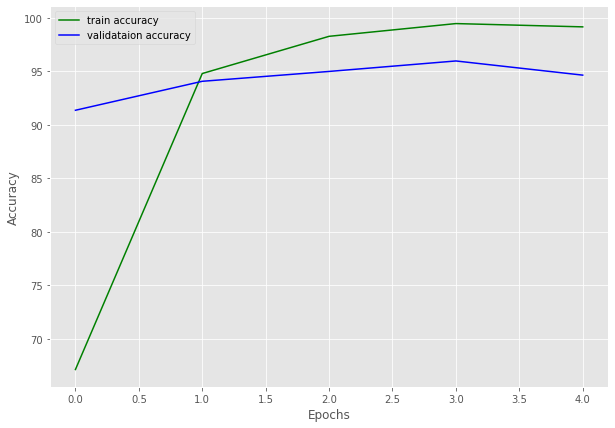

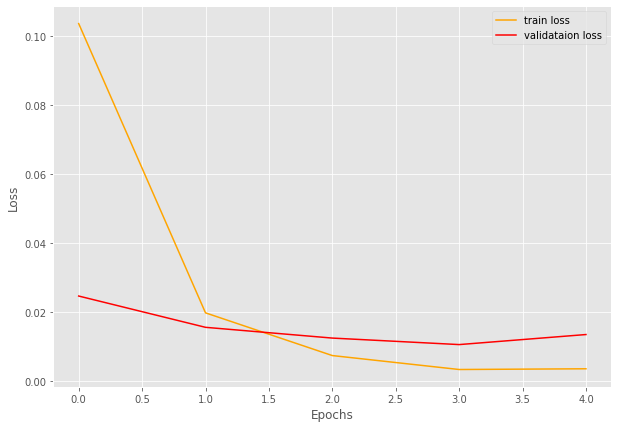

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
print(train_accuracy)
print(train_loss)
print(val_accuracy)
print(val_loss)

import joblib
joblib.dump(train_accuracy, 'train_accuracy.pkl')
joblib.dump(train_loss, 'train_loss.pkl')
joblib.dump(val_accuracy, 'val_accuracy.pkl')
joblib.dump(val_loss, 'val_loss.pkl')

[67.12776176753123, 94.79346781940441, 98.27089337175792, 99.46205571565802, 99.15465898174831]
[0.10355831969826411, 0.01982679200733544, 0.007464448281713223, 0.003428687591832149, 0.003637453398374728]
[91.3594470046083, 94.0668202764977, 94.98847926267281, 95.96774193548387, 94.64285714285714]
[0.024695064151479353, 0.015638680021334353, 0.012524952227893514, 0.010642152768881639, 0.01354932659713354]


['val_loss.pkl']

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('Accuracy of the network on test images: %0.3f %%' % (
    100 * correct / total))

Accuracy of the network on test images: 94.297 %


In [ ]:
pip install onnx

In [ ]:
model= ResNet34(pretrained=True)


In [ ]:
state_dict = torch.load('/content/drive/My Drive/resnet34_epochs5.pth')
model.load_state_dict(state_dict)
model

ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
dummy_input = torch.randn(64, 3, 7, 7)

In [ ]:
torch.onnx.export(model, dummy_input, "/content/drive/My Drive/torch_model.onnx")